In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/churn-detection/train.csv
/kaggle/input/churn-detection/test.csv


In [2]:
import pandas as pd
import numpy as np

In [3]:
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import f1_score
from xgboost import XGBClassifier
import matplotlib.pyplot as plt
import seaborn as sns

In [4]:
train_df = pd.read_csv('../input/churn-detection/train.csv')
test_df = pd.read_csv('../input/churn-detection/test.csv')

In [5]:
train_df.head()

,id,gender,SeniorCitizen,Partner,Dependents,tenure,PhoneService,MultipleLines,InternetService,OnlineSecurity,...,DeviceProtection,TechSupport,StreamingTV,StreamingMovies,Contract,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges,Churn
0,0,Male,0,Yes,No,51,Yes,Yes,DSL,No,...,No,Yes,Yes,Yes,Two year,Yes,Bank transfer (automatic),75.20,3901.25,No
1,1,Female,0,No,No,11,Yes,No,DSL,Yes,...,No,Yes,No,No,One year,Yes,Mailed check,54.60,617.85,No
2,2,Female,0,No,No,16,Yes,No,No,No internet service,...,No internet service,No internet service,No internet service,No internet service,One year,No,Bank transfer (automatic),20.10,318.6,No
3,3,Female,0,No,No,34,Yes,Yes,DSL,No,...,No,Yes,Yes,No,Month-to-month,No,Mailed check,65.00,2157.5,No
4,4,Female,1,Yes,No,43,Yes,Yes,Fiber optic,No,...,Yes,Yes,Yes,Yes,One year,Yes,Electronic check,107.55,4533.9,Yes


In [6]:
test_df.head()

,id,gender,SeniorCitizen,Partner,Dependents,tenure,PhoneService,MultipleLines,InternetService,OnlineSecurity,OnlineBackup,DeviceProtection,TechSupport,StreamingTV,StreamingMovies,Contract,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges
0,0,Female,0,Yes,No,9,Yes,No,DSL,No,Yes,No,No,No,No,Month-to-month,No,Mailed check,50.85,466.6
1,1,Female,0,No,No,18,Yes,Yes,DSL,No,No,No,No,No,No,Month-to-month,Yes,Electronic check,50.30,913.3
2,2,Female,0,Yes,No,64,Yes,No,No,No internet service,No internet service,No internet service,No internet service,No internet service,No internet service,Two year,No,Credit card (automatic),19.45,1225.65
3,3,Male,1,No,No,19,Yes,Yes,Fiber optic,No,No,Yes,No,No,No,Month-to-month,Yes,Electronic check,79.85,1471.75
4,4,Male,0,Yes,Yes,66,Yes,Yes,DSL,No,No,Yes,No,Yes,No,Two year,Yes,Bank transfer (automatic),63.30,4189.7


In [7]:
test_ids = test_df['id'] if 'id' in test_df.columns else test_df.index
test_df.drop('id', axis=1, inplace=True, errors='ignore')

In [8]:
train_df['Churn'] = train_df['Churn'].map({'No': 0, 'Yes': 1})
target = train_df['Churn']
train_df.drop('Churn', axis=1, inplace=True)

In [9]:
combined = pd.concat([train_df, test_df], axis=0)

In [10]:
def tenure_bucket(tenure):
    if tenure <= 12:
        return '0-1 year'
    elif tenure <= 24:
        return '1-2 years'
    elif tenure <= 48:
        return '2-4 years'
    elif tenure <= 60:
        return '4-5 years'
    else:
        return '5+ years'

In [11]:
combined['TenureGroup'] = combined['tenure'].apply(tenure_bucket)

In [12]:
combined['TotalSpent_est'] = combined['MonthlyCharges'] * combined['tenure']

In [13]:
combined['InternetService'] = combined['InternetService'].astype(str)
combined['InternetService_num'] = combined['InternetService'].map({
    'No': 0,
    'DSL': 1,
    'Fiber optic': 2,
    'Missing': -1
})

In [14]:
combined['IsSenior_Internet'] = combined['SeniorCitizen'] * combined['InternetService_num']

In [15]:
combined['TenureGroup'] = LabelEncoder().fit_transform(combined['TenureGroup'])

In [16]:
for col in combined.select_dtypes(include='object').columns:
    combined[col] = combined[col].fillna('Missing')
    combined[col] = LabelEncoder().fit_transform(combined[col].astype(str))

In [17]:
combined = combined.fillna(combined.median(numeric_only=True))

In [18]:
X_train = combined.iloc[:len(target)]
X_test = combined.iloc[len(target):]
y_train = target

In [19]:
X_tr, X_val, y_tr, y_val = train_test_split(X_train, y_train, test_size=0.2,
                                            random_state=42, stratify=y_train)

In [20]:
neg, pos = np.bincount(y_tr)
scale = neg / pos

In [21]:
model = XGBClassifier(
    use_label_encoder=False,
    eval_metric='logloss',
    random_state=42,
    scale_pos_weight=scale,
    max_depth=4,
    n_estimators=300,
    learning_rate=0.05,
    subsample=0.8,
    colsample_bytree=0.8
)

In [22]:
model.fit(X_tr, y_tr)

XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=0.8, device=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric='logloss',
              feature_types=None, gamma=None, grow_policy=None,
              importance_type=None, interaction_constraints=None,
              learning_rate=0.05, max_bin=None, max_cat_threshold=None,
              max_cat_to_onehot=None, max_delta_step=None, max_depth=4,
              max_leaves=None, min_child_weight=None, missing=nan,
              monotone_constraints=None, multi_strategy=None, n_estimators=300,
              n_jobs=None, num_parallel_tree=None, random_state=42, ...)

In [23]:
val_proba = model.predict_proba(X_val)[:, 1]
best_f1 = 0
best_thresh = 0.5
for t in np.arange(0.1, 0.9, 0.05):
    preds = (val_proba >= t).astype(int)
    f1 = f1_score(y_val, preds)
    print(f"Threshold={t:.2f} → F1={f1:.4f}")
    if f1 > best_f1:
        best_f1 = f1
        best_thresh = t
print(f"\nBest threshold = {best_thresh:.2f} | F1 = {best_f1:.4f}")

Threshold=0.10 → F1=0.5279
Threshold=0.15 → F1=0.5535
Threshold=0.20 → F1=0.5682
Threshold=0.25 → F1=0.5887
Threshold=0.30 → F1=0.6002
Threshold=0.35 → F1=0.6220
Threshold=0.40 → F1=0.6300
Threshold=0.45 → F1=0.6428
Threshold=0.50 → F1=0.6507
Threshold=0.55 → F1=0.6344
Threshold=0.60 → F1=0.6410
Threshold=0.65 → F1=0.6224
Threshold=0.70 → F1=0.6055
Threshold=0.75 → F1=0.5451
Threshold=0.80 → F1=0.4756
Threshold=0.85 → F1=0.4090

Best threshold = 0.50 | F1 = 0.6507


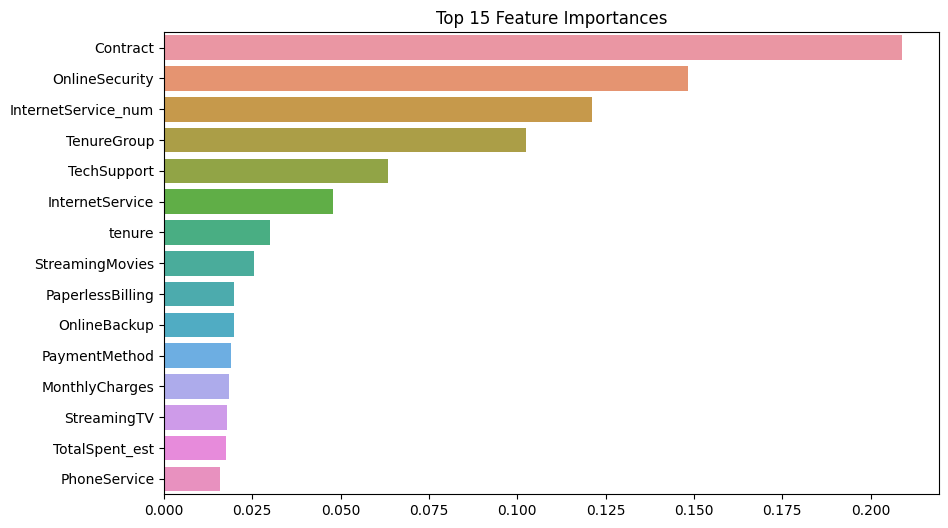

In [24]:
# --------- Feature Importance ----------
importances = model.feature_importances_
feat_imp = pd.Series(importances, index=X_train.columns).sort_values(ascending=False)
plt.figure(figsize=(10, 6))
sns.barplot(x=feat_imp.values[:15], y=feat_imp.index[:15])
plt.title("Top 15 Feature Importances")
plt.show()

In [25]:
test_proba = model.predict_proba(X_test)[:, 1]
test_pred = (test_proba >= best_thresh).astype(int)

In [26]:
test_pred_labels = pd.Series(test_pred).map({0: 'No', 1: 'Yes'})


In [27]:
submission = pd.DataFrame({
    'id': test_ids,
    'Churn': test_pred_labels
})

In [28]:
submission.to_csv("submission.csv", index=False)